Valsecchi et al. (2014) show that, in the limit of large $M_{\rm p}/M_\star$ and conservative mass transfer, $a/a_0 = \left(M_{\rm p}/M_{\rm p,\ 0} \right)^{-1/3}$ (Eqn 14), where $a/a_0$ is the final/initial semi-major axis and $M_{\rm p}/M_{\rm p,\ 0}$ the final/initial planetary mass. Based on this equation, where would we expect the remnants of hot Jupiters that have lost their atmospheres to end up?

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import brentq
import matplotlib._cntr as cntr

import astropy.units as u
from astropy.units import cds
from astropy.table import Table

plt.rcParams['contour.negative_linestyle'] = 'solid'

#Default aspect ratio for google slides
aspect_ratio = 4./3
default_fig_size = 6. #inches
default_fig_width = aspect_ratio*default_fig_size
default_fig_height = default_fig_size #"Heighth" is not a word.

In [51]:
def calc_smallq_roche_limit(q, Rp=0.1):
    return (q/3.)**(-1./3)*Rp

def Rappaport_Roche_limit(Mp=None, Rp=None, rhop=None):
    #Returns Roche limit period for given density
    #  based on Rappaport+ (2013) ApJL 773, L15.

    period0 = 9.6/24.*u.day #days

    if(rhop is None):
        rhop = Mp/(4.*np.pi/3.*Rp**3.)
    
    return period0*np.sqrt(1.*u.g/u.cm**3/(rhop.to('g/cm^3')))

#Returns period or semi-major axis, given the other
#  P in days, a in AU, and Mstar in solar masses
def Keplers_Third_Law(P=None, a=None, Mstar=1.*cds.Msun):

    bigG = 4.*np.pi*np.pi/cds.Msun*(cds.au*cds.au*cds.au)/(cds.yr*cds.yr)

    if((P is None) and (a is None)):
        raise ValueError("P or a must be given!")
    elif(a is not None):
        return (a*a*a/(bigG*Mstar/(4.*np.pi*np.pi)))**(1./2)
    elif(P is not None):
        return (P*P*(bigG*Mstar/(4.*np.pi*np.pi)))**(1./3)

print(Rappaport_Roche_limit(rhop=1*u.g/u.cm**3).to('hour'))

9.6 h


In [52]:
#typical hot Jupiter
Mp = 1.*cds.Mjup
Rp = 1.*cds.Rjup
Mcore = 10.*cds.Mgeo

#the Sun
Ms = 1.*cds.Msun
Rs = 1.*cds.Rsun

q = (Mp.to('kg')/Ms.to('kg')).value

a_Roche = calc_smallq_roche_limit(q, Rp=Rp)
P_Roche = Rappaport_Roche_limit(Mp, Rp)

#So where would the planet end up?
a = a_Roche*(Mcore/Mp)**(-1./3)
P = Keplers_Third_Law(a=a, Mstar=Ms)
print(a.to('au').value, P_Roche.to('day').value, P.to('day').value)

(0.02217335479484554, 0.35913876991932986, 1.2059723035426975)


Not too bad!

In [53]:
#These models come from Lopez & Fortney (2013 -- http://iopscience.iop.org/article/10.1088/0004-637X/792/1/1/meta)

def Lopez_core_radius(Mcore):
    MEarth = 1.*cds.Mgeo
    REarth = 1.*cds.Rgeo
    
    return ((Mcore/MEarth).value)**(0.25)*REarth

def Lopez_Renv(Mp, fenv=0.05, Fp=1., age=5e9*u.year):
    MEarth = 1.*cds.Mgeo
    fenv_baseline = 0.05
    Fp_baseline = 1.
    age_baseline = 5e9*u.year
    
    return 2.06*cds.Rgeo*((Mp/MEarth).value)**(-0.21)*\
            (fenv/fenv_baseline)**(0.59)*\
            (Fp/Fp_baseline)**(0.044)*\
            ((age/age_baseline).value)**(-0.18)

#Ignores the apparently small contribution from the radiative exterior
def Lopez_superearth_radius(Mp, fenv=0.05, Fp=1., age=5e9*u.year):
    Mcore = (1. - fenv)*Mp
#    Mcore = Mp
    Rcore = Lopez_core_radius(Mcore)
    
    Renv = Lopez_Renv(Mp, fenv=fenv, Fp=Fp, age=age)
    
    return (Rcore + Renv).value

print(Lopez_superearth_radius(1.78*cds.Mgeo, fenv=0.1))

3.87221142671


{8: '8', 2: '$2\\ {\\rm R_{Earth}}$', 4: '4', 6: '6'}


(-3.1, 0.1)

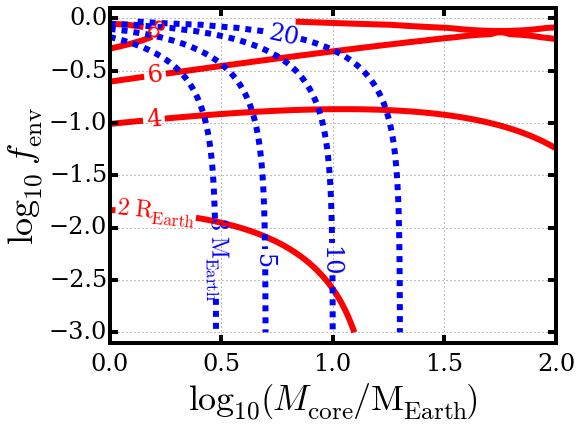

In [54]:
Mcores = 10**(np.linspace(0., 2., 100))*cds.Mgeo
fenvs = 10**(np.linspace(-3., 0., 101))
#Drop the very last one so I don't get a divide-by-zero error
fenvs = fenvs[:-1]

Mps = np.empty((len(Mcores), len(fenvs)))
Rps = np.empty((len(Mcores), len(fenvs)))
for i in range(len(Mcores)):
    for j in range(len(fenvs)):
        
        cur_Mp = Mcores[i]/(1. - fenvs[j])
        Mps[i,j] = cur_Mp.value
        Rps[i,j] = Lopez_superearth_radius(cur_Mp, fenv=fenvs[j])

fenvs = np.outer(np.ones_like(fenvs), fenvs)
Mcores = np.outer(Mcores, np.ones_like(Mcores))

fig = plt.figure(figsize=(default_fig_width, default_fig_height))
ax = fig.add_subplot(111)

locations = [(0.2, -2.), (0.2, -1.), (0.2, -0.5), (0.2, -0.1)]
lvls = [2, 4, 6, 8]
fmt = {lvls[0]: '$%i\ {\\rm R_{Earth}}$' % lvls[0]}
fmt.update({lvls[i]: '%i' % lvls[i] for i in range(1, len(lvls))})
print(fmt)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Rps, colors='r', linewidths=6, levels=lvls)
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locations)

locations = [(0.5, -2.3), (0.7, -2.3), (1., -2.3), (0.8, 0.)]
lvls = [3, 5, 10, 20]
fmt = {lvls[0]: '$%i\ {\\rm M_{Earth}}$' % lvls[0]}
fmt.update({lvls[i]: '%i' % lvls[i] for i in range(1, len(lvls))})
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Mps, colors='b', linewidths=6, linestyles='dashed', levels=lvls)
ax.clabel(CS, inline=1, fontsize=24, 
          fmt={3: '$%i\ {\\rm M_{Earth}}$' % 3, 5:'%i' % 5, 10:'%i' % 10, 20:'%i' % 20}, manual=locations)

ax.set_xlabel('$\\log_{10} \\left( M_{\\rm core}/{\\rm M_{Earth}}\\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\ f_{\\rm env}$', fontsize=36)

ax.set_xlim([0, 2])
ax.set_ylim([-3.1, 0.1])

#fig.savefig('LopezFortney2013_mass-radius_contours.eps', dpi=1000, bbox_inches='tight')

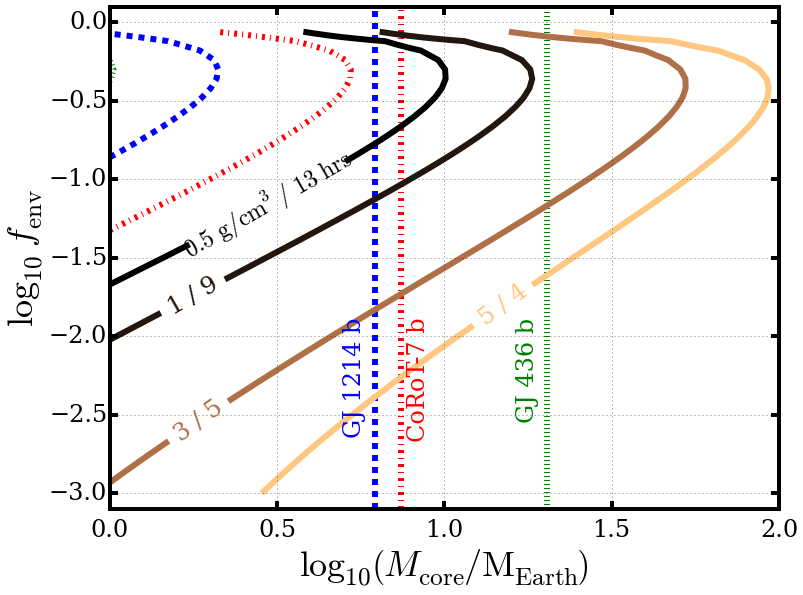

In [56]:
Mcores = 10**(np.linspace(0., 2., 50))*cds.Mgeo
fenvs = 10**(np.linspace(-3., 0., 51))
#Drop the very last one so I don't get a divide-by-zero error
fenvs = fenvs[:-1]

density = np.empty((len(Mcores), len(fenvs)))
Ps_Roche = np.empty((len(Mcores), len(fenvs)))
for i in range(len(Mcores)):
    for j in range(len(fenvs)):
        
        cur_Mp = Mcores[i]/(1. - fenvs[j])
        cur_Rp = Lopez_superearth_radius(cur_Mp, fenv=fenvs[j])*cds.Rgeo
        density[i,j] = (cur_Mp/(4.*np.pi/3.*cur_Rp**3)).to('g/cm^3').value
        Ps_Roche[i,j] = Rappaport_Roche_limit(rhop=density[i,j]*u.g/u.cm**3).to('hour').value

fenvs = np.outer(np.ones_like(fenvs), fenvs)
Mcores = np.outer(Mcores, np.ones_like(Mcores))

fig = plt.figure(figsize=(9*aspect_ratio, 9))
ax = fig.add_subplot(111)

lvls = [0.5, 1., 3., 5.]
density_lvls = Rappaport_Roche_limit(rhop=lvls*u.g/u.cm**3).to('hour').value
locs = [(0.5, -1.25), (0.25, -1.75), (0.25, -2.5), (1.25, -2)]
fmt = {lvls[0]: '$%.1f\ {\\rm g/cm^3}/\ %i\ {\\rm hrs}$' % (lvls[0], density_lvls[0])}
fmt.update({lvls[i]: '%i / %i' % (lvls[i], density_lvls[i]) for i in range(1, len(lvls))})
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), density, levels=lvls, cmap='copper', linewidths=6)
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locs)

#GJ 1214 b -- https://en.wikipedia.org/wiki/Gliese_1214_b
# Mp_lvls = [6.55]
# Rp_lvls = [2.678]
P_lvls = [1.58040456*24.]
#
#From Lopez & Fortney
Mcore = 6.46*(1. - 0.0383)
fenv = 0.0383
ax.axvline(np.log10(Mcore), zorder=-1, color='blue', lw=6, ls='--')
ax.text(np.log10(Mcore)*0.88, -2., 'GJ 1214 b', rotation='vertical', color='blue', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='blue', levels=P_lvls, linestyles='--', linewidths=6)

#CoRoT-7 b -- Lopez & Fortney (2013)
Mcore = 7.42
P_lvls = [0.853585*24.]
ax.axvline(np.log10(Mcore), color='red', zorder=-1, linestyle='-.', linewidth=6)
ax.text(np.log10(Mcore)*1.02, -2, 'CoRoT-7 b', rotation='vertical', color='red', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='red', levels=P_lvls, linestyles='-.', linewidths=6)

#Kepler-446 b -- http://exoplanets.org/detail/Kepler-446_b
# Mcore = 3.657
# ax.axvline(np.log10(Mcore), color='red')
# CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='blue', linewidths=8, levels=P_lvls)
# Rp_lvls = [2.678]

#GJ 436 b -- https://en.wikipedia.org/wiki/Gliese_436_b
Mcore = 23.0*(1. - 0.12)
# Rp_lvls = [4.327]
P_lvls = [2.643904*24.]
ax.axvline(np.log10(Mcore), color='green', zorder=-1, linestyle=':', linewidth=6)
ax.text(np.log10(Mcore)*0.93, -2, 'GJ 436 b', rotation='vertical', color='green', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='green', levels=P_lvls, linestyles=':', linewidths=6)

ax.set_xlabel('$\\log_{10} \\left( M_{\\rm core}/{\\rm M_{Earth}}\\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\ f_{\\rm env}$', fontsize=36)

ax.set_xlim([0, 2])
ax.set_ylim([-3.1, 0.1])

#fig.savefig('LopezFortney2013_density-PRoche_contours.eps', dpi=1000, bbox_inches='tight')

Now to convert these masses and radii to Roche limit periods.

(-3.1, 0.1)

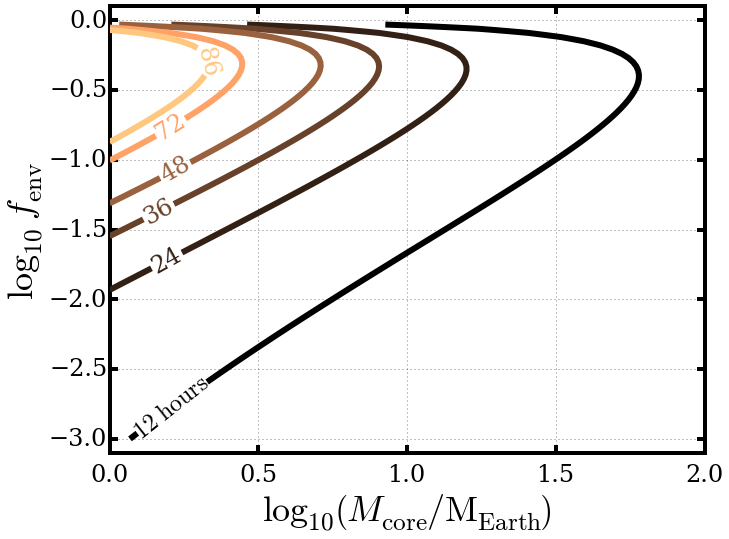

In [8]:
#Same PRoche vs. Mcore plot but without specific examples
Ps_Roche = Rappaport_Roche_limit(Mps*cds.Mgeo, Rps*cds.Rgeo).to('hour')
fig = plt.figure(figsize=(8*4./3,8))
ax = fig.add_subplot(111)

#ax.plot(Mps, Ps_Roche);

locations = [(0.2, -2.75), (0.2, -1.75), (0.2, -1.5), (0.2, -1.), (0.2, -0.75), (0.3, -0.3)]
lvls = [12, 24, 36, 48, 72, 86]
fmt = {lvls[0]: '$%i\ {\\rm hours}$' % lvls[0]}
fmt.update({lvls[i]: '%i' % lvls[i] for i in range(1, len(lvls))})
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, cmap='copper', linewidths=6, levels=lvls, zorder=3)
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locations)

ax.set_xlabel('$\\log_{10} \\left( M_{\\rm core}/{\\rm M_{Earth}}\\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\ f_{\\rm env}$', fontsize=36)

ax.set_xlim([0, 2])
ax.set_ylim([-3.1, 0.1])

#fig.savefig('Pturnover_without_examples.png', dpi=500, bbox_inches='tight')

(-3.1, 0.1)

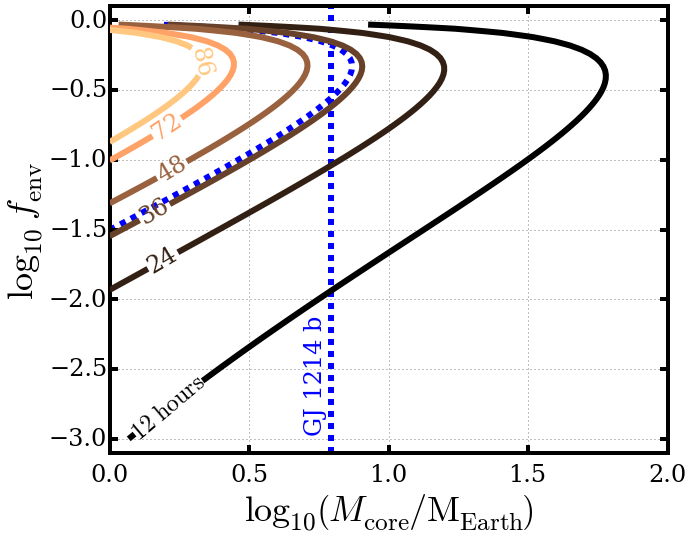

In [9]:
#And a version with only GJ 1214 b
Ps_Roche = Rappaport_Roche_limit(Mps*cds.Mgeo, Rps*cds.Rgeo).to('hour')
fig = plt.figure(figsize=(8*4/3,8))
ax = fig.add_subplot(111)

#ax.plot(Mps, Ps_Roche);

locations = [(0.2, -2.75), (0.2, -1.75), (0.2, -1.5), (0.2, -1.), (0.2, -0.75), (0.3, -0.3)]
lvls = [12, 24, 36, 48, 72, 86]
fmt = {lvls[0]: '$%i\ {\\rm hours}$' % lvls[0]}
fmt.update({lvls[i]: '%i' % lvls[i] for i in range(1, len(lvls))})
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, cmap='copper', linewidths=6, levels=lvls, zorder=3)
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locations)

# c = cntr.Cntr(Mcores, fenvs, Mps)
# level = 20.
# Mcores_Mp, fenvs_Mp = (c.trace(level))[0].T
# ax.fill_between(np.log10(Mcores_Mp), np.log10(fenvs_Mp), 1, facecolor='lightgrey', edgecolor='lightgrey', zorder=-1)

#GJ 1214 b -- https://en.wikipedia.org/wiki/Gliese_1214_b
# Mp_lvls = [6.55]
# Rp_lvls = [2.678]
P_lvls = [1.58040456*24.]
#
#From Lopez & Fortney
Mcore = 6.46*(1. - 0.0383)
fenv = 0.0383
ax.axvline(np.log10(Mcore), zorder=-1, color='blue', lw=6, ls='--')
ax.text(np.log10(Mcore)*0.88, -2.25, 'GJ 1214 b', rotation='vertical', color='blue', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='blue', levels=P_lvls, linestyles='--', linewidths=6)

ax.set_xlabel('$\\log_{10} \\left( M_{\\rm core}/{\\rm M_{Earth}}\\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\ f_{\\rm env}$', fontsize=36)

ax.set_xlim([0, 2])
ax.set_ylim([-3.1, 0.1])
#fig.savefig('Pturnover_with_just_GJ1214b.png', dpi=500, bbox_inches='tight')

TypeError: Shape of x does not match that of z: found (50, 50) instead of (100, 100).

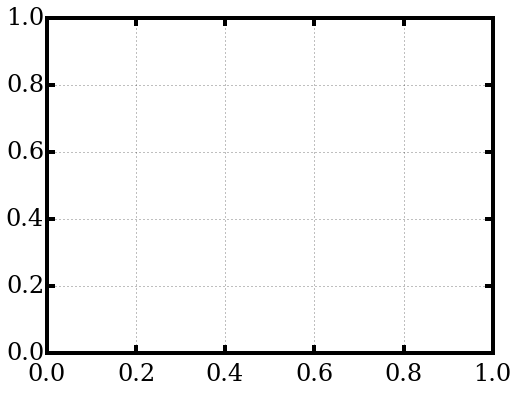

In [62]:
Ps_Roche = Rappaport_Roche_limit(Mps*cds.Mgeo, Rps*cds.Rgeo).to('hour')
fig = plt.figure(figsize=(default_fig_width,default_fig_height))
ax = fig.add_subplot(111)

#ax.plot(Mps, Ps_Roche);

locations = [(0.2, -2.75), (0.2, -1.75), (0.2, -1.5), (0.2, -1.), (0.2, -0.75), (0.3, -0.3)]
lvls = [12, 24, 36, 48, 72, 86]
fmt = {lvls[0]: '$%i\ {\\rm hours}$' % lvls[0]}
fmt.update({lvls[i]: '%i' % lvls[i] for i in range(1, len(lvls))})
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, cmap='copper', linewidths=6, levels=lvls, zorder=3)
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locations)

# c = cntr.Cntr(Mcores, fenvs, Mps)
# level = 20.
# Mcores_Mp, fenvs_Mp = (c.trace(level))[0].T
# ax.fill_between(np.log10(Mcores_Mp), np.log10(fenvs_Mp), 1, facecolor='lightgrey', edgecolor='lightgrey', zorder=-1)

#GJ 1214 b -- https://en.wikipedia.org/wiki/Gliese_1214_b
# Mp_lvls = [6.55]
# Rp_lvls = [2.678]
P_lvls = [1.58040456*24.]
#
#From Lopez & Fortney
Mcore = 6.46*(1. - 0.0383)
fenv = 0.0383
ax.axvline(np.log10(Mcore), zorder=-1, color='blue', lw=6, ls='--')
ax.text(np.log10(Mcore)*0.88, -2., 'GJ 1214 b', rotation='vertical', color='blue', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='blue', levels=P_lvls, linestyles='--', linewidths=6)

#CoRoT-7 b -- Lopez & Fortney (2013)
Mcore = 7.42
P_lvls = [0.853585*24.]
ax.axvline(np.log10(Mcore), color='red', zorder=-1, linestyle='-.', linewidth=6)
ax.text(np.log10(Mcore)*1.02, -2, 'CoRoT-7 b', rotation='vertical', color='red', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='red', levels=P_lvls, linestyles='-.', linewidths=6)

#Kepler-446 b -- http://exoplanets.org/detail/Kepler-446_b
# Mcore = 3.657
# ax.axvline(np.log10(Mcore), color='red')
# CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='blue', linewidths=8, levels=P_lvls)
# Rp_lvls = [2.678]

#GJ 436 b -- https://en.wikipedia.org/wiki/Gliese_436_b
Mcore = 23.0*(1. - 0.12)
# Rp_lvls = [4.327]
P_lvls = [2.643904*24.]
ax.axvline(np.log10(Mcore), color='green', zorder=-1, linestyle=':', linewidth=6)
ax.text(np.log10(Mcore)*0.93, -2, 'GJ 436 b', rotation='vertical', color='green', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='green', levels=P_lvls, linestyles=':', linewidths=6)

# # CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Mps, colors='blue', linewidths=8, levels=Mp_lvls, linestyles='--')
# # CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Rps, colors='red', linewidths=8, levels=Rp_lvls, linestyles='--')

# #55 Cnc e -- L & F
# Mcore = 8.32
# P_lvls = [0.7365449*24.]
# ax.axvline(np.log10(Mcore), color='cornflowerblue')
# CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='cornflowerblue', levels=P_lvls)

# #K-10 b -- L & F
# Mcore = 4.51
# P_lvls = [0.837495*24.]
# ax.axvline(np.log10(Mcore), color='gold')
# CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='gold', levels=P_lvls)

# lvls = [20]
# CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Mps, colors='grey', linewidths=6, levels=lvls, zorder=-1)

#ax.plot(np.log10(Mcores_Mp), np.log10(f(Mcores_Mp)), color='k')
#ax.plot(np.log10(Mcores_Mp), np.log10(fenvs_Mp), color='grey')

ax.set_xlabel('$\\log_{10} \\left( M_{\\rm core}/{\\rm M_{Earth}}\\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\ f_{\\rm env}$', fontsize=36)

ax.set_xlim([0, 2])
ax.set_ylim([-3.1, 0.1])

#fig.savefig('Pturnover_with_examples.eps', dpi=1000, bbox_inches='tight')

In [57]:
LF_Table7 = Table.read('combined_LopezFortney2014_Table7_exoplanets-org.csv', format='ascii.csv')
#print(LF_Table7['H/He Envelope Fraction'])

#Add in the calculated core mass
LF_Table7['Mcore'] = LF_Table7['Mass (M_oplus)']*(1. - LF_Table7['H/He Envelope Fraction'])

In [58]:
c = cntr.Cntr(Mcores, fenvs, Ps_Roche)
level = 0.35500744*24.
Mcores_P, fenvs_P = (c.trace(level))[0].T
mx_ind = np.argmax(Mcores_P)
print(Mcores_P[mx_ind])

22.7239438256


In [59]:
def find_turnover_Mcore(period):
    c = cntr.Cntr(Mcores, fenvs, Ps_Roche)
    Mcores_P, fenvs_P = (c.trace(period))[0].T
    return Mcores_P.max()

1.87414010574e-06


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: invalid value encountered in power


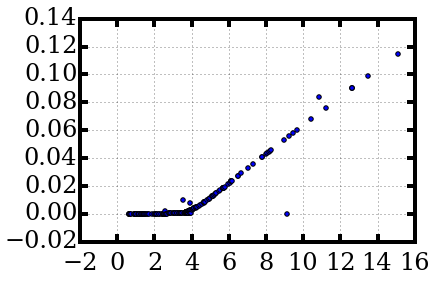

In [60]:
def calc_fenv(Mp, Rp, Fp=1., age=5e9):
    Renv0 = 2.06
    age0 = 5e9 #years
    fenv0 = 0.05
    
    #Assumes Earth mass
    Rcore = Mp**0.25

    #Assumes Earth radius
    Renv = Rp - Rcore
    
    return ((Renv/Renv0)*(Mp**(0.21))/(Fp**0.044)*(age/age0)**(0.18))**(1./0.59)*fenv0
    
exoplanets_table = Table.read('exoplanets-org_2015Nov19.csv', format='ascii.csv')
exoplanets_table['fenv'] = calc_fenv(exoplanets_table['MASS (Mearth)'], exoplanets_table['R (Rearth)'])
exoplanets_table['Mcore'] = exoplanets_table['MASS (Mearth)']*(1. - exoplanets_table['fenv'])

possible_fenv_ind = (exoplanets_table['R (Rearth)'] - Lopez_superearth_radius(exoplanets_table['MASS (Mearth)'], fenv=0.) > 0)
plt.scatter(exoplanets_table['MASS (Mearth)'][possible_fenv_ind], exoplanets_table['fenv'][possible_fenv_ind])
print(exoplanets_table['fenv'][possible_fenv_ind].min())

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


IndexError: list index out of range

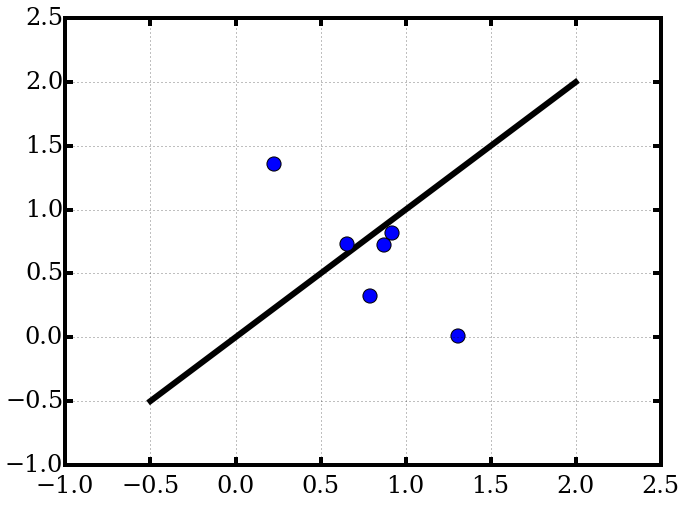

In [61]:
#Version for my NMSU talk
fig = plt.figure(figsize=(8*4./3,8))
ax = fig.add_subplot(111)

ind = np.where(LF_Table7['PER'] < 3.)
#ax.scatter(LF_Table7['PER'], LF_Table7['Mcore'])

turnover_Mcore = []
for cur_per in LF_Table7['PER'][ind]:
    turnover_Mcore = np.append(turnover_Mcore, find_turnover_Mcore(cur_per*24.))
ax.scatter(np.log10(LF_Table7['Mcore'][ind]), np.log10(turnover_Mcore), s=200)

xyrange = [-0.5, 2.]
ax.plot(xyrange, xyrange, lw=6, zorder=-1, color='k')

#and then add the ones I calculated
ind = np.where(exoplanets_table['PER (day)'] < 3.)
turnover_Mcore = []
for cur_per in exoplanets_table['PER (day)'][ind]:
    turnover_Mcore = np.append(turnover_Mcore, find_turnover_Mcore(cur_per*24.))
ax.scatter(np.log10(exoplanets_table['Mcore'][ind]), np.log10(turnover_Mcore), s=200)

ax.set_xlim(xyrange)
ax.set_ylim(xyrange)

ax.text(-0.45, 1.75, '$P < P_{\\rm turnover}$', fontsize=48)
ax.text(0.9, -0.35, '$P > P_{\\rm turnover}$', fontsize=48)

ax.set_xlabel('$\\log_{10}\\left( M_{\\rm core,\ obs}/{\\rm M_{Earth}} \\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\\left( M_{\\rm core,\ exp}/{\\rm M_{Earth}} \\right)$', fontsize=36)

#fig.savefig('Mcore-exp_vs_Mcore-obs.png', dpi=500, bbox_inches='tight')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


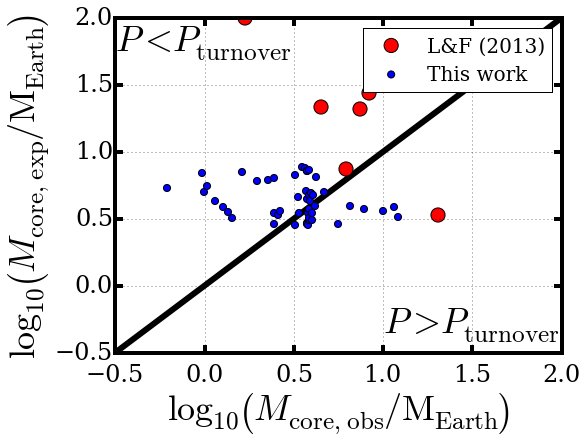

In [36]:
#fig = plt.figure(figsize=(8,8))
fig = plt.figure(figsize=(default_fig_width,default_fig_height))
ax = fig.add_subplot(111)

ind = np.where(LF_Table7['PER'] < 3.)
#ax.scatter(LF_Table7['PER'], LF_Table7['Mcore'])

turnover_Mcore = []
for cur_per in LF_Table7['PER'][ind]:
    turnover_Mcore = np.append(turnover_Mcore, find_turnover_Mcore(cur_per*24.))
ax.scatter(np.log10(LF_Table7['Mcore'][ind]), np.log10(turnover_Mcore), s=200, facecolor='red', edgecolor='black', 
           label='L&F (2013)')

xyrange = [-0.5, 2.]
ax.plot(xyrange, xyrange, lw=6, zorder=-1, color='k')

#and then add the ones I calculated
ind = np.where(exoplanets_table['PER (day)'] < 3.)
turnover_Mcore = []
for cur_per in exoplanets_table['PER (day)'][ind]:
    turnover_Mcore = np.append(turnover_Mcore, find_turnover_Mcore(cur_per*24.))
ax.scatter(np.log10(exoplanets_table['Mcore'][ind]), np.log10(turnover_Mcore), s=200, marker='.', 
           facecolor='blue', edgecolor='black', zorder=0, label='This work')

ax.set_xlim(xyrange)
ax.set_ylim(xyrange)

ax.text(-0.5, 1.75, '$P < P_{\\rm turnover}$', fontsize=36)
ax.text(1, -0.35, '$P > P_{\\rm turnover}$', fontsize=36)

ax.set_xlabel('$\\log_{10}\\left( M_{\\rm core,\ obs}/{\\rm M_{Earth}} \\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\\left( M_{\\rm core,\ exp}/{\\rm M_{Earth}} \\right)$', fontsize=36)

ax.legend(loc='upper right', fontsize=20, scatterpoints=1)
fig.savefig('P-vs-Pturnover.eps', dpi=1000, bbox_inches='tight')

Make Roche period plot

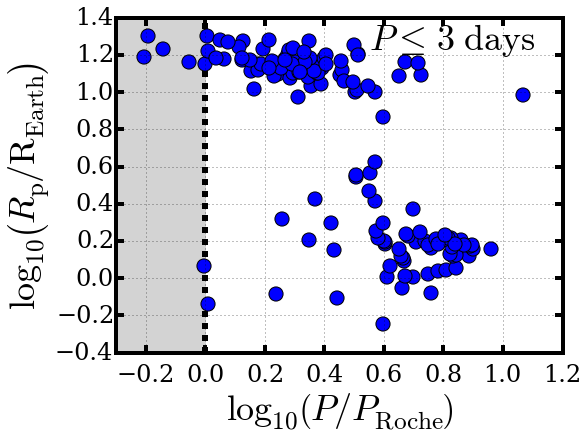

In [38]:
fig = plt.figure(figsize=(default_fig_width,default_fig_height))
ax = fig.add_subplot(111)

exoplanets_table = Table.read('exoplanets-org_2015Dec7.csv', format='ascii.csv')

ind = np.where(exoplanets_table['PER (day)'] < 3.)
exoplanets_table['PRoche (days)'] = \
    Rappaport_Roche_limit(exoplanets_table['MASS (Mearth)']*cds.Mgeo, exoplanets_table['R (Rearth)']*cds.Rgeo)

x = exoplanets_table['PER (day)'][ind]/exoplanets_table['PRoche (days)'][ind]
y = exoplanets_table['R (Rearth)'][ind]
ax.scatter(np.log10(x), np.log10(y), s=200)
ax.axvline(0., lw=6, ls='--', color='k', zorder=-1)

ax.set_xlim([-0.3, 1.2])
ax.set_ylim([-0.4, 1.4])

ax.fill_between([-0.3, 0.], -0.4, 1.4, color='lightgrey', zorder=-1)

ax.set_xlabel('$\\log_{\\rm 10} \\left( P/P_{\\rm Roche} \\right)$', fontsize=36)
ax.set_ylabel('$\\log_{\\rm 10} \\left( R_{\\rm p}/{\\rm R_{Earth}} \\right)$', fontsize=36)

ax.text(0.55, 1.23, '$P \\leq\ {\\rm 3\ days}$', fontsize=36)
fig.savefig('P-PRoche.eps', dpi=1000, bbox_inches='tight')